# Dog Breed Identification
## Farhad Navid 

### transfer learning with Aug data set

* Load data set
* Load weights from ImageNet features for pretrained VGG19 model "block4_pool".
* Run model
* Create train and test
* Run SVM model
* Record the performance. 

In [1]:
# initialization
import matplotlib.pyplot as plt 
import PIL
import pandas as pd
import os
import glob
import time
import numpy as np
import h5py
import tensorflow as tf
#import deepdish as dd

from array import *

from tqdm import tqdm
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D 

from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam

from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score,confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import train_test_split


%matplotlib inline
K.set_image_dim_ordering( 'tf' )

Using TensorFlow backend.


This next block of code does represent the Directory structure of the data once the repository was selected.  In this instance the [**AWS**](https://www.AWS.Amazon.com/) (paid service) were utilized.  

In [2]:
# directory structure of the data

dpath_train = '/home/ubuntu/train'      # Data path to training data set
dpath_test  = '/home/ubuntu/test'       # Data path to test data set
dpath       = '/home/ubuntu'
label_f     = '/home/ubuntu/labels.csv' # Path to the label file 

**Load the augmented data file** 

In [ ]:
# Retrive already created data set with Augmented Images
import deepdish as dd
Aug_train_data = '/home/ubuntu/train_aug_data.hdf5' #
f= dd.io.load(Aug_train_data)
X_train_aug = f['X']
y_train_aug = f['Y']

In [3]:
# point to location of the Train images
images = glob.glob('/home/ubuntu/train/*.jpg')
img_data = []
# resize and add new axis to images
for i in tqdm(images):
    img = image.load_img(i, target_size=(224, 224))
    img_data.append(image.img_to_array(img)[np.newaxis, :, :, :])
# concatenate the images    
tr_img_data_np = np.concatenate(img_data, )
# save them as "unsigned Integer" for the smaller size.
tr_img_data_np = tr_img_data_np.astype('uint8')
# create the label 
labels = pd.read_csv(label_f)

100%|██████████| 10222/10222 [02:31<00:00, 67.55it/s]


In [4]:
print(tr_img_data_np.shape,tr_img_data_np.dtype)

(10222, 224, 224, 3) uint8


In [5]:
'''
    @parameters:
        dataset: the feature training dataset in numpy array with shape [num_examples, num_rows, num_cols, num_channels] (since it is an image in numpy array)
        dataset_labels: the corresponding training labels of the feature training dataset in the same order, and numpy array with shape [num_examples, <anything>]
        augmentation_factor: how many times to perform augmentation.
        use_random_rotation: whether to use random rotation. default: true
        use_random_shift: whether to use random shift. default: true
        use_random_shear: whether to use random shear. default: true
        use_random_zoom: whether to use random zoom. default: true
        
    @returns:
        augmented_image: augmented dataset
        augmented_image_labels: labels corresponding to augmented dataset in order.
        
    for the augmentation techniques documentation, go here:
        https://www.tensorflow.org/api_docs/python/tf/contrib/keras/preprocessing/image/random_rotation
        https://www.tensorflow.org/api_docs/python/tf/contrib/keras/preprocessing/image/random_shear
        https://www.tensorflow.org/api_docs/python/tf/contrib/keras/preprocessing/image/random_shift
        https://www.tensorflow.org/api_docs/python/tf/contrib/keras/preprocessing/image/random_zoom
'''
def augment_data(dataset, dataset_labels, augementation_factor=1, use_random_rotation=True, use_random_shear=True, use_random_shift=True, use_random_zoom=True):
    augmented_image = []
    augmented_image_labels = []

    for num in tqdm(range(0, dataset.shape[0])):  # tqdm progress bar
        for i in range(0, augementation_factor):
            # original image:
            augmented_image.append(dataset[num])
            augmented_image_labels.append(dataset_labels[num])

            if use_random_rotation:
                
                augmented_image.append(tf.contrib.keras.preprocessing.image.random_rotation(dataset[num], 20, row_axis=0, col_axis=1, channel_axis=2))
                augmented_image_labels.append(dataset_labels[num])

            if use_random_shear:
                augmented_image.append(tf.contrib.keras.preprocessing.image.random_shear(dataset[num], 0.2, row_axis=0, col_axis=1, channel_axis=2))
                augmented_image_labels.append(dataset_labels[num])

            if use_random_shift:
                augmented_image.append(tf.contrib.keras.preprocessing.image.random_shift(dataset[num], 0.2, 0.2, row_axis=0, col_axis=1, channel_axis=2))
                augmented_image_labels.append(dataset_labels[num])

            if use_random_zoom:
                # update: zoomrange (second arg) should be tuple of floats
                augmented_image.append(tf.contrib.keras.preprocessing.image.random_zoom(dataset[num], (0.9, 0.9), row_axis=0, col_axis=1, channel_axis=2))
                augmented_image_labels.append(dataset_labels[num])

    return np.array(augmented_image), np.array(augmented_image_labels)

In [6]:
# Augment train data set this will increase the data set size by 5X
aug_images, aug_labels = augment_data(tr_img_data_np, labels.breed)

100%|██████████| 10222/10222 [06:43<00:00, 25.35it/s]


In [7]:
# check point make sure the size and shape are as expected.
print(aug_images.shape,aug_labels.shape,aug_images.dtype)
# Make sure the data type is expected.
aug_images.dtype

(51110, 224, 224, 3) (51110,) uint8


dtype('uint8')

In [8]:
# Now let's make sure we have all the unique dog names identified and chk the total number.

unique_Dog_Breed = []
for i in aug_labels:
    if i not in unique_Dog_Breed:
        unique_Dog_Breed.append(i)
    
unique_Dog_Breed.sort()   # Now sort the unique lable alphabatically. Next we need to count howmany unique label

count = 0
unique_Dog_Breed_Num = []   # integer assiciated with every unique Dog name

# with the next loops we are creating integers for each unique labels. in prepration of catagorizing the Y.

for i in unique_Dog_Breed:
    unique_Dog_Breed_Num.append([i, count])
    count += 1

for i in range(len(aug_labels)):
    for j in unique_Dog_Breed_Num:
        if aug_labels[i] == j[0]:
            aug_labels[i] = j[1]
            break

print("unique Dog Breed Numbers = ",len(unique_Dog_Breed_Num))
y_train = to_categorical(aug_labels)

unique Dog Breed Numbers =  120


In [9]:
print(y_train.shape, y_train.dtype)

(51110, 120) float32


In [ ]:
# now save to hdf5 

#os.chdir(dpath)
with h5py.File('traindata_aug.hdf5','w') as f:
    f.create_dataset('X', data=aug_images)
    f.create_dataset('Y', data=y_train)
# # Save the X_train and y_train to a HD5 file with Deep Dish. 
# import deepdish as dd
# Aug_train_data = '/home/ubuntu/train_aug_data.hdf5'
# dd.io.save(Aug_train_data, {'X': aug_images, 'Y': aug_labels}, compression=('blosc', 9))

In [10]:
X_train_aug = aug_images
y_train_aug = y_train

In [11]:
print(X_train_aug.shape,X_train_aug.dtype,y_train_aug.shape,y_train_aug.dtype)

(51110, 224, 224, 3) uint8 (51110, 120) float32


### Notes
**Only 10000 images of the 51110 images are used**

Due to the size of the input file and the number of features for the **block4_pool** could not run the model completely. A different strategy is required to run the full model and that was beyond the time scope of this project.  
following is the example of max number of images we could process without getting the memory error.


In [12]:
X_train_s = X_train_aug[:25000] 
y_train_s = y_train_aug[:25000]

## Transfer Learning

In [13]:
# transfer learning
# Get the weigths from imagenet for the VGG19 model
base_model = VGG19(weights='imagenet')
# now select the layer to get the features from in this case "block4_pool" was selected
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

# Create a zero Numpy array with the shape of np.zero((Xs_train.shape[0],(block4_pool_features))) 
# for this modle the (image#,14,14,512)

train_set = np.zeros((X_train_s.shape[0],4096))

## This section of code was written to findout the dimmention of the Block4_pool_features.

# x = preprocess_input(X_train[1])  # get one sample of X_train
# print(x.shape)                    # Chk the shape 
# x = np.expand_dims(x,axis=0)      # Ad the image num to the list
# print(x.shape)                    # Check the shape

# block4_pool_features_org = model.predict(x)  # Create one entry to see the shape

# this loop will fill the train_set numpy array (each x_train runs through model with extracted VGG features)
for i in tqdm(range(X_train_s.shape[0])):
#    K.clear_session()
    x = preprocess_input(X_train_s[i])
    x = np.expand_dims(x,axis=0)
    block4_pool_features = model.predict(x)
    train_set[i]=block4_pool_features


100%|██████████| 25000/25000 [13:56<00:00, 29.89it/s]


In [14]:
block4_pool_features.shape

(1, 4096)

In [15]:
# converting the y_train from one hot encoding to integer
ytrain_1 = np.array(y_train_s)
ytrain1_rdy = [np.where(r==1)[0][0] for r in ytrain_1]

In [16]:
ytrain1_rdy[:10]

[19, 19, 19, 19, 19, 37, 37, 37, 37, 37]

### Create Train and Test data set for SVM model

In [17]:
# we split training data in to train and test. 

train_set = train_set.reshape(train_set.shape[0],-1)
X= train_set
y= ytrain1_rdy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## SVM model
* **Model Fit**
* **Model Prediction**

In [18]:
# Run the svm 

t0=time.time()
clf = SVC()
clf.fit(X_train, y_train)
t1=time.time()
print(t1-t0,"seconds")

# predict 
t0=time.time()
pred_Train=clf.predict(X_train) 
pred_Test=clf.predict(X_test) 
t1=time.time()
print(t1-t0,"seconds")
# print(pred_Train[:10],pred_Test[:10])
# print(clf.predict([train_set[5]]))

4257.880242824554 seconds
2783.9085755348206 seconds


## Performance
* Cohen's Kappa Score
* Accuracy score
* classification report
* F1 Score
* confusion matrix (This matrix was not selected since the entire model did not run and result was not as interesting)

In [20]:
print(cohen_kappa_score(y_train, pred_Train),'Train data set cohen kappa score')
print(cohen_kappa_score(y_test, pred_Test),'Test data set cohen kappa score')

confusion_matrix(y_train, pred_Train)

print(accuracy_score(y_train, pred_Train),'Accuracy Score Train Data set')
print(accuracy_score(y_test, pred_Test), 'Accuracy Score Test Data set')

print(classification_report(y_train, pred_Train))
print(classification_report(y_test, pred_Test))

print(metrics.f1_score(y_train, pred_Train,average='weighted'),'matrics f1 score train data set')
print(metrics.f1_score(y_test, pred_Test,average='weighted'),'matrics f1 score test data set')

0.998520598581634 Train data set cohen kappa score
0.9794159555888344 Test data set cohen kappa score
0.9985333333333334 Accuracy Score Train Data set
0.9796 Accuracy Score Test Data set
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       187
          1       1.00      1.00      1.00       232
          2       1.00      1.00      1.00       182
          3       1.00      1.00      1.00       236
          4       1.00      1.00      1.00       147
          5       1.00      1.00      1.00       183
          6       0.98      1.00      0.99       218
          7       1.00      1.00      1.00       224
          8       1.00      1.00      1.00       176
          9       1.00      1.00      1.00       237
         10       1.00      1.00      1.00       248
         11       1.00      0.98      0.99       245
         12       1.00      0.98      0.99       202
         13       1.00      1.00      1.00       218
         14      

In [22]:
cm = confusion_matrix(y_train, pred_Train)

In [24]:
target_names = unique_Dog_Breed


## Ploting the Confusion Matrix
* **The Plotting routine was barrowed [Source](https://www.kaggle.com/grfiv4/plot-a-confusion-matrix)** 

In [30]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

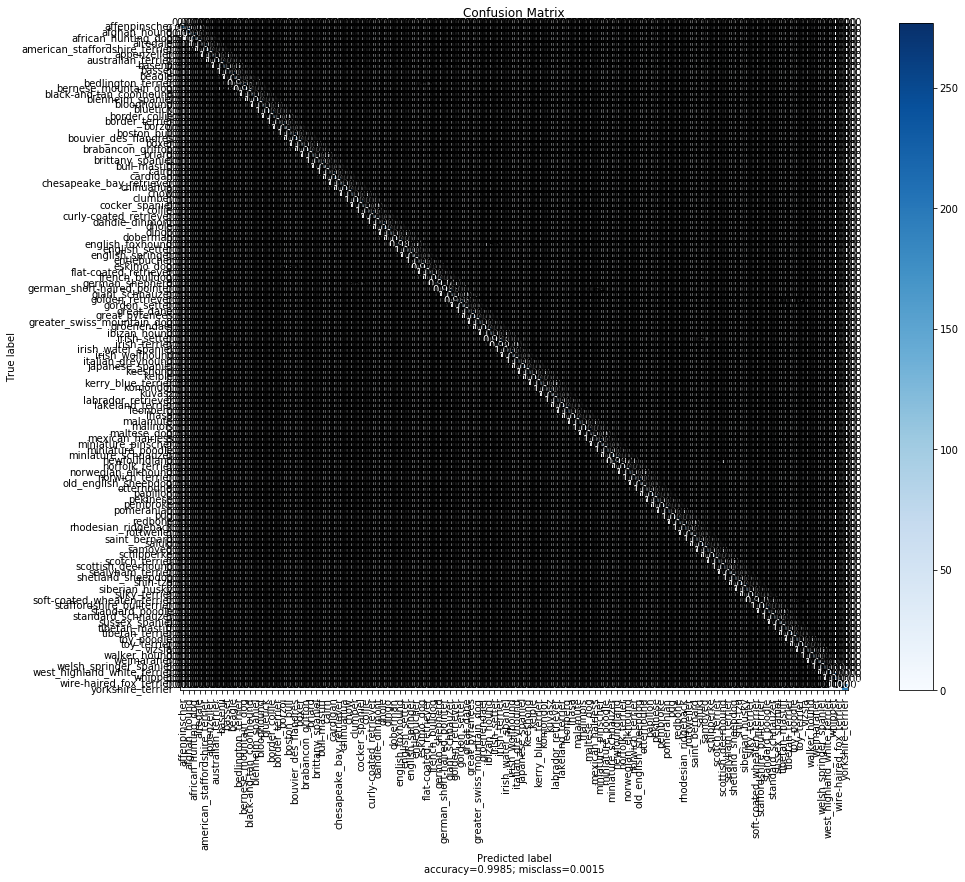

In [31]:
plot_confusion_matrix(cm           = confusion_matrix(y_train, pred_Train), 
                      normalize    = True,
                      target_names = unique_Dog_Breed,
                      title        = "Confusion Matrix")